# Team Banking Fraud

## Goals

* __Business Goal:__ A legacy rules engine is already in place to detect fraud. Our goal is to create a data science model that can beat the legacy system in detecting fraud.

* __Learning Goal:__ Team members have no prior experience with data science. Our goals are to gain experience with data retrieval, feature engineering, model training, and results analysis.


## Retrieve Data

In [ ]:
# Download data from:
# https://www.kaggle.com/ntnu-testimon/paysim1

# Unzip the data
#!unzip paysim1.zip

# Copy data
#!aws s3 cp s3://team-banking-fraud/PS_20174392719_1491204439457_log.csv data.csv


Read the data file and take a quick look at the data. Using `df.shape` we can see that there are 6,362,620 rows and 11 columns.

In [2]:
import pandas as pd

filename = '../PS_20174392719_1491204439457_log.csv'

df = pd.read_csv(filename)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(6362620, 11)

The __type__ column contains five catagorical values. These will have to be one hot encoded for use in the model. 

In [4]:
df["type"].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

Below are the value counts for the __nameDest__ column. Both the __nameDest__ column and the __nameOrig__ column contain over two million catagorical values. We will want to remove these columns before doing one hot encoding and training the model.

In [5]:
df["nameDest"].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
C977993101      96
C97730845       96
C392292416      95
C1899073220     92
C306206744      91
C1782113663     90
C1234776885     90
C716083600      89
C998351292      89
C909295153      88
C1674899618     86
C667346055      86
C1262822392     85
C453211571      84
C1255024717     84
C1816757085     84
C2006081398     83
C1504109395     82
C991363637      82
C932583850      82
              ... 
M241124516       1
M1929009582      1
M787407762       1
M701653275       1
M1845729441      1
M1823667542      1
M1536727506      1
M1518201855      1
M1666845973      1
M680415425       1
M737076588       1
M1298704313      1
M1194295572      1
M640304928       1
M542130089       1
M1402664140      1
M1062166453      1
M2142318694      1
M1930358603      1
M761711955       1
M1864117407      1
M1037733299 

The __isFraud__ column is our target/label column. There are 8,213 rows that have been identified and confirmed as fraud.

In [6]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

As shown below only about .1% of all transactions are fraudulant

In [7]:
print(8213/(6354407 + 8213))

0.001290820448180152


The __step__ column represents the hour of the month in which the tranactions occured. A histogram of the __step__ column shows that most of the transactions happen earlier in the month.



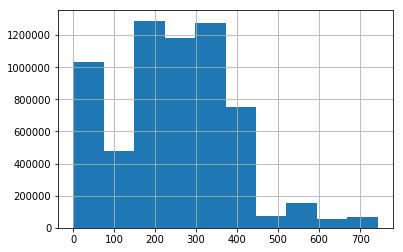

In [8]:
import matplotlib

%matplotlib inline
df["step"].hist()

A correlation matrix of the data shows that __amount__ and __step__ have the most correlation with __isFraud__. Also of note, the __oldbalanceDest__ and __newbalanceDest__ are highly correlated.

In [10]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


The fraud data is fairly clean; there are no missing values.

## Drop id columns

As mentioned previously we want to drop the __nameOrig__ and __nameDest__ columns because the contains over two million unqiue categaorical values. If we were to include these columns we would need to one hot encode them which would produce over 4 million additional columns.

In [11]:
#df = pd.get_dummies(df, ["type"])
df2 = df.drop(["nameOrig","nameDest"], axis=1)
list(df2.columns)

['step',
 'type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [12]:
df2.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


### One Hot Encode type Column

We want to one hot encode the __type__ column so that we can include the values in the model. 

In [13]:
df3 = pd.get_dummies(df2, columns=["type"])
df3.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [14]:
list(df3.columns)

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'type_CASH_IN',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER']

In [15]:
df3.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277,0.004077,-0.012918,0.002869,0.004926,0.006925
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295,-0.009621,-0.004376,-0.023379,-0.197444,0.365896
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835,0.506761,-0.200899,-0.021450,-0.189486,-0.081593
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776,0.527373,-0.210977,-0.021872,-0.193915,-0.087355
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513,0.076105,0.086028,0.009347,-0.231455,0.130476
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529,0.034988,0.093476,0.006346,-0.238315,0.191701
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109,-0.019089,0.011256,-0.002911,-0.025697,0.053869
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000,-0.000842,-0.001168,-0.000128,-0.001133,0.005245
type_CASH_IN,0.004077,-0.009621,0.506761,0.527373,0.076105,0.034988,-0.019089,-0.000842,1.000000,-0.391047,-0.042987,-0.379522,-0.160535
type_CASH_OUT,-0.012918,-0.004376,-0.200899,-0.210977,0.086028,0.093476,0.011256,-0.001168,-0.391047,1.000000,-0.059625,-0.526422,-0.222672


Our intuition lead to think that a __newbalanceOrig__ of 0 might indicate fraud, so we create a special binary column to indicate if the __newbalanceOrig__ is 0 (i.e., an empty account)

In [16]:
df3["accountEmptied"] = 0

In [17]:
for idx, row in df3.iterrows():
    newBalance = row['newbalanceOrig']
    if newBalance == 0:
        df3.at[idx, 'accountEmptied'] = 1
    else:
        df3.at[idx, 'accountEmptied'] = 0
df3.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,accountEmptied
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0,1
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0,0


Over half the accounts were emptied, which lead to conversation about the quality of this bank.  
1 = account is empty  
0 = account not empty

In [18]:
df3['accountEmptied'].value_counts()

1    3609566
0    2753054
Name: accountEmptied, dtype: int64

In [19]:
df3.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,accountEmptied
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277,0.004077,-0.012918,0.002869,0.004926,0.006925,0.005390
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295,-0.009621,-0.004376,-0.023379,-0.197444,0.365896,0.115566
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835,0.506761,-0.200899,-0.021450,-0.189486,-0.081593,-0.323722
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776,0.527373,-0.210977,-0.021872,-0.193915,-0.087355,-0.334857
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513,0.076105,0.086028,0.009347,-0.231455,0.130476,0.041383
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529,0.034988,0.093476,0.006346,-0.238315,0.191701,0.079761
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109,-0.019089,0.011256,-0.002911,-0.025697,0.053869,0.029984
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000,-0.000842,-0.001168,-0.000128,-0.001133,0.005245,-0.001816
type_CASH_IN,0.004077,-0.009621,0.506761,0.527373,0.076105,0.034988,-0.019089,-0.000842,1.000000,-0.391047,-0.042987,-0.379522,-0.160535,-0.607976
type_CASH_OUT,-0.012918,-0.004376,-0.200899,-0.210977,0.086028,0.093476,0.011256,-0.001168,-0.391047,1.000000,-0.059625,-0.526422,-0.222672,0.475586


XGBoost expects the first column of the input to be the target/label so make __isFraud__ the first column.

In [22]:
df3 = df3[['isFraud', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'accountEmptied']]
list(df3.columns)

['isFraud',
 'step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud',
 'type_CASH_IN',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER',
 'accountEmptied']

# First Test

In [23]:

df_all_columns = df3

In [24]:
import numpy as np

model_data = df_all_columns
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7*len(model_data)), int(0.9*len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

# Train
See https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb

In [25]:
import boto3
import os

bucket = 'team-banking-fraud'
prefix = 'SageMaker'
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [26]:
import sagemaker

from sagemaker import get_execution_role
role = get_execution_role()

from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')


s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')



In [27]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    base_job_name = 'frud',
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-01-30 17:17:19 Starting - Starting the training job...
2020-01-30 17:17:20 Starting - Launching requested ML instances......
2020-01-30 17:18:24 Starting - Preparing the instances for training......
2020-01-30 17:19:31 Downloading - Downloading input data...
2020-01-30 17:19:53 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:20:26] 4453834x13 matrix with 57899842 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimit

## Deploy
Deploy model and test it using our test data

In [31]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------------!

In [32]:
from sagemaker.predictor import csv_serializer

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [33]:

# Now, we'll use a simple function to:
#
# 1. Loop over our test dataset
# 2. Split it into mini-batches of rows
# 3. Convert those mini-batchs to CSV string payloads
# 4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
# 5. Collect predictions and convert from the CSV output our model provides into a NumPy array

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [34]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,635414,21
1,162,665


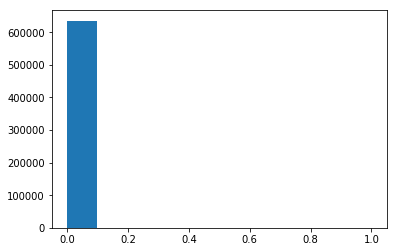

In [35]:
import matplotlib.pyplot as plt

plt.hist(predictions)
plt.show()

## First Test

Confusion Matric

| predictions |	0.0 | 1.0 |
|-------------|-----|-----|
| actual	0 |	635414 | 21 |
|		    1 | 162	|    665|


		

In [36]:

def summary(true_neg, false_pos, false_neg, true_pos):
    total_predictions = true_neg + false_pos + false_neg + true_pos
    pos_predictions = false_pos + true_pos
    positive_samples = false_neg + true_pos

    recall = true_pos / positive_samples
    precision = true_pos / pos_predictions
    accuracy = (true_pos + true_neg)/ total_predictions

    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'accuracy: {accuracy}')

summary(true_neg=635414, false_pos=21, false_neg=162, true_pos=665)



recall: 0.8041112454655381
precision: 0.9693877551020408
accuracy: 0.9997123826348265


# Second Test

For the second test we removed columns from the input dataset that we thought did not help to predict that target.

In [30]:
df4 = df3[['isFraud', 'step', 'amount', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_TRANSFER', 'accountEmptied']]


In [37]:
df_selected_columns = df4

In [50]:
removed_columns = set(df_all_columns.columns) - set(df_selected_columns.columns)
list(removed_columns)

['oldbalanceOrg',
 'type_PAYMENT',
 'type_CASH_OUT',
 'isFlaggedFraud',
 'type_CASH_IN',
 'type_DEBIT']

In [38]:
model_data = df_selected_columns
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7*len(model_data)), int(0.9*len(model_data))])
train_data.to_csv('train2.csv', header=False, index=False)
validation_data.to_csv('validation2.csv', header=False, index=False)
test_data.to_csv('test2.csv', header=False, index=False)

In [40]:
bucket = 'team-banking-fraud'
prefix = 'SageMaker'
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train2/train.csv')).upload_file('train2.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation2/validation.csv')).upload_file('validation2.csv')

In [41]:
import sagemaker

from sagemaker import get_execution_role
role = get_execution_role()

from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')


s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train2'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation2/'.format(bucket, prefix), content_type='csv')

In [42]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    base_job_name = 'frud',
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.2xlarge',
                                    output_path='s3://{}/{}/output2'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-01-30 17:55:36 Starting - Starting the training job...
2020-01-30 17:55:37 Starting - Launching requested ML instances.........
2020-01-30 17:57:09 Starting - Preparing the instances for training.........
2020-01-30 17:59:06 Downloading - Downloading input data...
2020-01-30 17:59:18 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:59:43] 4453834x7 matrix with 31176838 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined de

In [43]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

-------------------!

In [44]:
from sagemaker.predictor import csv_serializer

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [45]:
predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [46]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,635412,23
1,258,569


In [47]:
summary(635412, 23, 258, 569)

recall: 0.6880290205562273
precision: 0.9611486486486487
accuracy: 0.9995583580348976


## Results

### First Test  

The First test has 80% recall which means that 20% of the time we cannot identify the fraud.  
__recall:__ 0.8041112454655381  

Precision was at 96% which means the 96% we identified fraud correctly, while 4% of the time we identified it incorrectly.  
__precision:__ 0.9693877551020408  

And accuracy was at 99%:  
__accuracy:__ 0.9997123826348265  

### Second Test

Our second test should a decline in recall with approximately the same perceision and accuracy.

__recall:__ 0.6880290205562273  
__precision:__ 0.9611486486486487  
__accuracy:__ 0.9995583580348976  


----

In [62]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner
#import sagemaker.tuner.IntegerParameter

objective_metric_name = "validation:auc"
hyperparameter_ranges = {'eta': ContinuousParameter(0,1), 
                         'min_child_weight': ContinuousParameter(1,10), 
                         'alpha': ContinuousParameter(0,2), 
                         'max_depth': IntegerParameter(1,10)}
tuner = HyperparameterTuner(xgb, objective_metric_name, hyperparameter_ranges, max_jobs=20, max_parallel_jobs=3)

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})


In [63]:
xgb_tuned = sagemaker.estimator.Estimator(container,
                                    role,
                                    base_job_name = 'frud',
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.2xlarge',
                                    output_path='s3://{}/{}/output2'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb_tuned.set_hyperparameters(max_depth=10,
                        alpha=1.6837832934635877,
                        eta=0.4280415046799866,
                        gamma=4,
                        min_child_weight=8.073739357352355,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb_tuned.fit({'train': s3_input_train, 'validation': s3_input_validation})




2020-01-30 19:52:30 Starting - Starting the training job...
2020-01-30 19:52:31 Starting - Launching requested ML instances......
2020-01-30 19:53:36 Starting - Preparing the instances for training...
2020-01-30 19:54:25 Downloading - Downloading input data
2020-01-30 19:54:25 Training - Downloading the training image...
2020-01-30 19:54:45 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:54:47] 4453834x7 matrix with 31176838 entries loaded from /opt/ml/i

In [64]:
xgb_tuned_predictor = xgb_tuned.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

-------------------!

In [65]:
xgb_tuned_predictor.content_type = 'text/csv'
xgb_tuned_predictor.serializer = csv_serializer
xgb_tuned_predictor.deserializer = None

In [66]:
def predict2(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_tuned_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict2(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [67]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,635409,26
1,248,579
